## Data preprocessing (scATAC-seq)

In this notebook, I follow the scATAC-seq preprocessing procedure described in **scDCT**.

> For scATAC-seq data, which typically contain hundreds of thousands of sparse features, we first binarize the count matrix and retain peaks detected in at least 0.5% of cells to remove uninformative regions. Inspired by the effectiveness of Term Frequency–Inverse Document Frequency (TF-IDF) transformation in chromatin accessibility analysis, we apply TF-IDF weighting followed by global max normalization to obtain the processed peak matrix $X_a \in \mathbb{R}^{C \times J}$, where $J$ is the number of retained chromatin-accessible regions.

**Reference:** [scDCT: a conditional diffusion-based deep learning model for high-fidelity single-cell cross-modality translation](https://academic.oup.com/bib/article/26/4/bbaf400/8223492)


_______________________________________________________________________________________________________________________________________

## 1- Load scATAC-seq (ATAC) dataset

This section loads the scATAC-seq dataset (peak accessibility matrix) into an AnnData object.

**Inputs**
- `data_dir`: directory path containing the file/folder  
- `file_name`: dataset name (e.g., `.h5ad` file )

After loading, we verify the object and print basic summary statistics (cells, peaks, and available metadata fields).


In [15]:
# --- Code cell: Load scATAC-seq dataset ---

import os
import scanpy as sc
import anndata as ad
import scipy.sparse as sp
import numpy as np

# =========================
# User inputs
# =========================
data_dir = "/home/khodadadi/pbmc_preprocess"         
file_name = "10x-Multiome-Pbmc10k-ATAC.h5ad"           

path = os.path.join(data_dir, file_name)

# =========================
# Load
# =========================
if os.path.isfile(path) and path.endswith(".h5ad"):
    atac = sc.read_h5ad(path)

elif os.path.isdir(path):
    # For 10x Genomics peak matrix folders (e.g., filtered_peak_bc_matrix)
    # This expects matrix.mtx(.gz), barcodes.tsv(.gz), peaks.bed (or features.tsv(.gz) depending on export)
    # scanpy's reader handles 10x mtx layouts; for peaks it often reads features as "var".
    atac = sc.read_10x_mtx(
        path,
        var_names="gene_symbols",  # for ATAC this may still populate var; we'll rename later if needed
        cache=True
    )
else:
    raise FileNotFoundError(f"Could not find a valid .h5ad file or 10x folder at: {path}")

# Optional: make sure matrix is sparse (ATAC usually is)
if not sp.issparse(atac.X):
    atac.X = sp.csr_matrix(atac.X)

# =========================
# Quick verification / summary
# =========================
print("Loaded scATAC AnnData:")
print(atac)
print("\nShape (cells x peaks/features):", atac.shape)


# Sparsity / nonzero stats
nnz = atac.X.nnz
total = atac.shape[0] * atac.shape[1]
sparsity = 1 - (nnz / total)
print(f"\nNonzeros (nnz): {nnz:,}")
print(f"Sparsity: {sparsity:.4f}")

# If var_names look like genes but you expect peaks, just show a few examples
print("\nFirst 5 var_names (should represent peaks/regions):")
print(atac.var_names[:5].to_list())

print("\nFirst 5 obs_names (cell barcodes):")
print(atac.obs_names[:5].to_list())


Loaded scATAC AnnData:
AnnData object with n_obs × n_vars = 9631 × 107194
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts'

Shape (cells x peaks/features): (9631, 107194)

Nonzeros (nnz): 71,252,543
Sparsity: 0.9310

First 5 var_names (should represent peaks/regions):
['chr1:816881-817647', 'chr1:819912-823500', 'chr1:825827-825889', 'chr1:826612-827979', 'chr1:841243-843059']

First 5 obs_names (cell barcodes):
['AAACAGCCAATCCCTT-1', 'AAACAGCCAATGCGCT-1', 'AAACAGCCACCAACCG-1', 'AAACAGCCAGGATAAC-1', 'AAACAGCCAGTTTACG-1']


________________________________________________________________________________________________________________
## 2- Binarize the scATAC-seq count matrix

Following **scDCT**, we **binarize** the scATAC-seq peak count matrix to convert it into a binary accessibility matrix.

**Goal:**  
Replace raw counts with **presence/absence**:
- If a peak has **any** reads in a cell → set value to **1**
- Otherwise → set value to **0**

Formally, for the original matrix $X$:
$$
X^{\text{bin}}_{ij} =
\begin{cases}
1 & \text{if } X_{ij} > 0 \\
0 & \text{otherwise}
\end{cases}
$$


This step reduces the influence of read depth and keeps only whether each peak is accessible in each cell.


In [16]:
import scipy.sparse as sp
import numpy as np

# Assume your AnnData object is named: atac
X = atac.X

# (Optional but recommended) keep original counts
atac.layers["counts"] = X.copy()

# Create final binarized matrix named atac_bin
if sp.issparse(X):
    atac_bin = X.copy().tocsr()
    atac_bin.data = np.ones_like(atac_bin.data, dtype=np.float32)  # set all nonzeros to 1
else:
    atac_bin = (X > 0).astype(np.float32)

# Store binarized matrix
atac.layers["binary"] = atac_bin

print("Binarization done.")
print(
    "Original counts number of non-zero entries (nnz):",
    atac.layers["counts"].nnz if sp.issparse(atac.layers["counts"]) else np.count_nonzero(atac.layers["counts"])
)
print(
    "Binary nnz:",
    atac.layers["binary"].nnz if sp.issparse(atac.layers["binary"]) else np.count_nonzero(atac.layers["binary"])
)

# Quick sanity check: unique values in a small slice
if sp.issparse(atac.layers["binary"]):
    sample = atac.layers["binary"][:100, :100].toarray()
else:
    sample = atac.layers["binary"][:100, :100]
print("Unique values in a 100x100 slice:", np.unique(sample))

# Also show the output object info
print("atac_bin type:", type(atac_bin), "| shape:", atac_bin.shape)


Binarization done.
Original counts number of non-zero entries (nnz): 71252543
Binary nnz: 71252543
Unique values in a 100x100 slice: [0. 1.]
atac_bin type: <class 'scipy.sparse._csr.csr_matrix'> | shape: (9631, 107194)


____________________________________________________________________________________________________________________________________________
## 3- Filter peaks detected in ≥ 0.5% of cells

Following **scDCT**, after binarization we remove uninformative peaks by keeping only peaks that are detected (accessible) in at least **0.5% of cells**.

Let $X^{\text{bin}} \in \{0,1\}^{C \times J}$ be the binarized peak matrix.  
For each peak $j$, we compute its **detection frequency** (number of cells where the peak is present):

$$
df_j = \sum_{i=1}^{C} X^{\text{bin}}_{ij}
$$

We keep peak $j$ if:

$$
\frac{df_j}{C} \ge 0.005
\quad\Longleftrightarrow\quad
df_j \ge 0.005 \times C
$$

This step reduces sparsity by discarding peaks that are almost always zero.


In [17]:
# --- Code cell: Keep peaks detected in >= 0.5% of cells (do NOT modify atac) ---

import numpy as np
import scipy.sparse as sp

# Use binarized matrix from previous step
X_bin = atac_bin  # (cells x peaks)
C, J = X_bin.shape

min_pct = 0.005
min_cells = int(np.ceil(min_pct * C))

# df_j = number of cells where peak j is detected (since X_bin is binary)
if sp.issparse(X_bin):
    df = np.asarray(X_bin.sum(axis=0)).ravel()
else:
    df = X_bin.sum(axis=0)

keep_mask = df >= min_cells

# Create filtered matrix as its own variable (no changes to atac)
if sp.issparse(X_bin):
    atac_bin_filt = X_bin[:, keep_mask].tocsr()
else:
    atac_bin_filt = X_bin[:, keep_mask].astype(np.float32)

# Report counts
n_keep = int(keep_mask.sum())
n_removed = int(J - n_keep)

print("Peak filtering (>= 0.5% cells) done.")
print(f"Cells (C): {C:,}")
print(f"Original peaks (J): {J:,}")
print(f"Peaks kept: {n_keep:,} ({(n_keep/J)*100:.2f}%)")
print(f"Peaks removed: {n_removed:,} ({(n_removed/J)*100:.2f}%)")
print("Filtered binary matrix saved as: atac_bin_filt")
print("New shape (cells x peaks):", atac_bin_filt.shape)


Peak filtering (>= 0.5% cells) done.
Cells (C): 9,631
Original peaks (J): 107,194
Peaks kept: 99,272 (92.61%)
Peaks removed: 7,922 (7.39%)
Filtered binary matrix saved as: atac_bin_filt
New shape (cells x peaks): (9631, 99272)


---
## 4- TF–IDF weighting for scATAC-seq peaks

Following **scDCT**, after binarization and peak filtering, we apply **TF–IDF (Term Frequency–Inverse Document Frequency)** weighting to the scATAC-seq peak matrix to obtain a more informative representation for downstream modeling.

### Steps (TF–IDF)

- **Input (filtered binary peak matrix):**  
  Let $X \in \{0,1\}^{C \times J}$ be the filtered binarized scATAC matrix, where $C$ is the number of cells and $J$ is the number of retained peaks.

- **1) Compute per-cell total accessible peaks:**  
  For each cell $i$:  
  $$
  n_i = \sum_{k=1}^{J} X_{ik}
  $$

- **2) Compute Term Frequency (TF) (cell-wise normalization):**  
  For each cell $i$ and peak $j$:  
  $$
  \mathrm{TF}_{ij} = \frac{X_{ij}}{n_i}
  $$
  **Why:** This reduces bias from cells with different sequencing depth / overall accessibility.

- **3) Compute peak detection frequency (document frequency):**  
  For each peak $j$:  
  $$
  df_j = \sum_{i=1}^{C} X_{ij}
  $$

- **4) Compute Inverse Document Frequency (IDF) (peak-wise weighting):**  
  For each peak $j$:  
  $$
  \mathrm{IDF}_j = \log\left(1 + \frac{C}{1 + df_j}\right)
  $$
  **Why:** Peaks open in many cells are less informative, so they get down-weighted; rare peaks become more informative and get up-weighted.

- **5) Combine TF and IDF to get TF–IDF weighted matrix:**  
  $$
  X^{\mathrm{TFIDF}}_{ij} = \mathrm{TF}_{ij} \cdot \mathrm{IDF}_j
  $$

### Why we do TF–IDF for scATAC-seq

- **Normalizes per-cell coverage** (TF) so cells are comparable.  
- **Emphasizes cell-type–specific peaks** and suppresses ubiquitous peaks (IDF).  
- Produces a representation that is widely effective for sparse chromatin accessibility data and helps downstream learning.


In [18]:
# --- TF-IDF weighting for scATAC (no global max normalization here) ---

import numpy as np
import scipy.sparse as sp

# Input: filtered binarized matrix (cells x peaks), values 0/1
X = atac_bin_filt  # (C x J)
C, J = X.shape

# 1) TF: TF_ij = X_ij / n_i, where n_i = sum_k X_ik
if sp.issparse(X):
    row_sum = np.asarray(X.sum(axis=1)).ravel()
else:
    row_sum = X.sum(axis=1)

row_sum[row_sum == 0] = 1.0  # avoid division by zero

if sp.issparse(X):
    TF = sp.diags(1.0 / row_sum) @ X
else:
    TF = (X / row_sum[:, None]).astype(np.float32)

# 2) IDF: IDF_j = log(1 + C/(1 + df_j)), df_j = sum_i X_ij
if sp.issparse(X):
    df = np.asarray(X.sum(axis=0)).ravel()
else:
    df = X.sum(axis=0)

IDF = np.log1p(C / (1.0 + df))  # shape (J,)

# 3) TF-IDF: X_tfidf = TF * IDF (column scaling)
if sp.issparse(TF):
    atac_tfidf = TF @ sp.diags(IDF)
else:
    atac_tfidf = (TF * IDF[None, :]).astype(np.float32)

print("TF-IDF weighting done.")
print("atac_tfidf shape:", atac_tfidf.shape)


TF-IDF weighting done.
atac_tfidf shape: (9631, 99272)


---
## 5- Global max normalization (scATAC-seq)

After TF–IDF weighting, **scDCT** applies **global max normalization** to scale the entire matrix into a comparable range.

Let $X^{\mathrm{TFIDF}}$ be the TF–IDF weighted matrix. We compute the global maximum value:

$$
m = \max_{i,j}\left(X^{\mathrm{TFIDF}}_{ij}\right)
$$

Then we normalize every entry by this maximum:

$$
X_a = \frac{X^{\mathrm{TFIDF}}}{m}
$$

This produces the final processed peak matrix $X_a \in \mathbb{R}^{C \times J}$.


In [19]:
# --- Global max normalization: final variable name atac_bin_filt_TFIDF_norm ---

import numpy as np
import scipy.sparse as sp

X_tfidf = atac_tfidf  # from TF-IDF step

if sp.issparse(X_tfidf):
    max_val = X_tfidf.max()
else:
    max_val = float(np.max(X_tfidf))

if max_val > 0:
    atac_bin_filt_TFIDF_norm = X_tfidf / max_val
else:
    atac_bin_filt_TFIDF_norm = X_tfidf

print("Done. Final matrix name: atac_bin_filt_TFIDF_norm")
print("Shape:", atac_bin_filt_TFIDF_norm.shape)
print("Global max before normalization:", max_val)


Done. Final matrix name: atac_bin_filt_TFIDF_norm
Shape: (9631, 99272)
Global max before normalization: 0.0023399633


## 6- PCA visualization (scATAC-seq)

To visually inspect the processed scATAC-seq data, we compute a PCA-like low-dimensional representation
and plot the first two components.

Because scATAC matrices are extremely high-dimensional and sparse, we use **TruncatedSVD**
(which is the standard PCA-equivalent for sparse matrices) to compute components without densifying the matrix.

Each cell is colored by its **cell type** annotation.


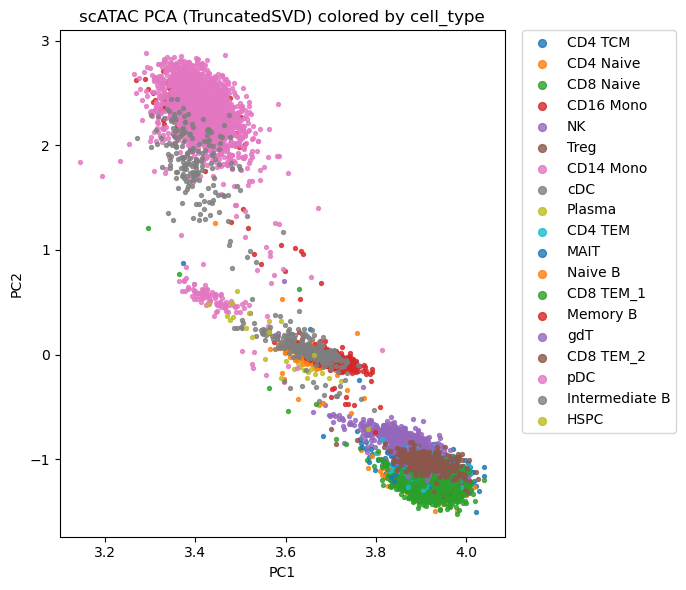

In [20]:
# --- PCA-like visualization for sparse scATAC (TruncatedSVD) ---

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Use processed matrix (Xa)
X = atac_bin_filt_TFIDF_norm # (cells x peaks), can be sparse

# ---- pick a cell-type column robustly ----
candidate_cols = [
    "cell_type", "celltype", "CellType", "celltypes",
    "annotation", "annot", "label", "labels",
    "cell_type_l2", "cell_type_l1",
    "seurat_clusters", "leiden"
]
celltype_col = next((c for c in candidate_cols if c in atac.obs.columns), None)

if celltype_col is None:
    raise ValueError(
        "Could not find a cell-type column in atac.obs. "
        f"Available columns: {list(atac.obs.columns)}"
    )

celltypes = atac.obs[celltype_col].astype(str)

# ---- TruncatedSVD (PCA for sparse matrices) ----
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=0)
Z = svd.fit_transform(X)  # shape: (cells, n_components)

# ---- Plot PC1 vs PC2, one color per cell type (matplotlib default color cycle) ----
plt.figure(figsize=(7, 6))

for ct in pd.unique(celltypes):
    idx = (celltypes == ct).values
    plt.scatter(Z[idx, 0], Z[idx, 1], s=8, alpha=0.8, label=ct)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"scATAC PCA (TruncatedSVD) colored by {celltype_col}")
plt.legend(markerscale=2, bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


_____________________________________________________________________________________________________________
## 7- Save the final processed scATAC-seq data

We save:
- The final preprocessed scATAC AnnData object containing the processed peak matrix $X_a$ (`.h5ad`)
- Optionally, the processed peak matrix $X_a$ as a sparse `.npz` (or dense `.npy` if it is dense)
- Cell barcodes and retained peak identifiers for reproducibility


In [21]:
import os
import numpy as np
import scipy.sparse as sp
import anndata as ad

def save_preprocessed_atac(
    atac_bin_filt_TFIDF_norm,
    atac_obs,
    atac_peak_names,
    out_dir: str,
    base_name: str = "pbmc_atac_preprocessed_tfidf_maxnorm",
    
):
    """
    Save the final preprocessed ATAC matrix X_a + AnnData + cell/peak IDs.

    Outputs (written into out_dir):
      - {base_name}.h5ad
      - {base_name}_X_a.npz   (if sparse) OR {base_name}_X_a.npy (if dense)
      - {base_name}_cells_barcodes.txt
      - {base_name}_peaks.txt

    Parameters
    ----------
    atac_bin_filt_TFIDF_norm : scipy.sparse matrix or numpy.ndarray
        Final processed ATAC matrix X_a (TF-IDF + global max norm), shape (cells x peaks).
    atac_obs : pandas.DataFrame
        Cell metadata (atac.obs).
    atac_peak_names : array-like
        Names/IDs of retained peaks, length = number of columns inatac_bin_filt_TFIDF_norm.
    out_dir : str
        Directory to save outputs (created if it doesn't exist).
    base_name : str
        Prefix for all output files.

    Returns
    -------
    dict
        Paths to saved files.

    """
    out_dir = os.path.expanduser(out_dir)
    os.makedirs(out_dir, exist_ok=True)

    out_h5ad  = os.path.join(out_dir, f"{base_name}.h5ad")
    out_cells = os.path.join(out_dir, f"{base_name}_cells_barcodes.txt")
    out_peaks = os.path.join(out_dir, f"{base_name}_peaks.txt")

    # Build AnnData and save
    adata_atac = ad.AnnData(
        X=atac_bin_filt_TFIDF_norm,
        obs=atac_obs.copy(),
        var={"peak": np.array(atac_peak_names, dtype=str)}
    )
    adata_atac.var_names = np.array(atac_peak_names, dtype=str)
    adata_atac.write_h5ad(out_h5ad)

    # Save matrix X_a
    X = atac_bin_filt_TFIDF_norm
    if sp.issparse(X):
        out_X = os.path.join(out_dir, f"{base_name}_X_a.npz")
        sp.save_npz(out_X, X.tocsr())
    else:
        out_X = os.path.join(out_dir, f"{base_name}_X_a.npy")
        np.save(out_X, X)

    # Save IDs
    np.savetxt(out_cells, adata_atac.obs_names.astype(str), fmt="%s")
    np.savetxt(out_peaks, adata_atac.var_names.astype(str), fmt="%s")

    print("Saved:")
    print(" - AnnData:", out_h5ad)
    print(" - X_a    :", out_X)
    print(" - Cells  :", out_cells)
    print(" - Peaks  :", out_peaks)

    return {
        "h5ad": out_h5ad,
        "X_a": out_X,
        "cells": out_cells,
        "peaks": out_peaks,
    }


In [22]:
# peaks kept after filtering (must match atac_bin_filt_TFIDF_norm columns)
atac_peaks_filt = atac.var_names[keep_mask]

# save
paths = save_preprocessed_atac(
    atac_bin_filt_TFIDF_norm=atac_bin_filt_TFIDF_norm,
    atac_obs=atac.obs,
    atac_peak_names=atac_peaks_filt,
    out_dir="/home/khodadadi/pbmc_preprocess/ATAC_PBMC_Preprocessed",
    base_name="pbmc_atac_bin_filt_TFIDF_norm"
)


Saved:
 - AnnData: /home/khodadadi/pbmc_preprocess/ATAC_PBMC_Preprocessed/pbmc_atac_bin_filt_TFIDF_norm.h5ad
 - X_a    : /home/khodadadi/pbmc_preprocess/ATAC_PBMC_Preprocessed/pbmc_atac_bin_filt_TFIDF_norm_X_a.npz
 - Cells  : /home/khodadadi/pbmc_preprocess/ATAC_PBMC_Preprocessed/pbmc_atac_bin_filt_TFIDF_norm_cells_barcodes.txt
 - Peaks  : /home/khodadadi/pbmc_preprocess/ATAC_PBMC_Preprocessed/pbmc_atac_bin_filt_TFIDF_norm_peaks.txt
